<a href="https://www.kaggle.com/code/ernestbeardlypani/icr-identifying-age-related-conditions-eda?scriptVersionId=138268568" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initializations

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr/pip-packages
Processing /kaggle/input/pip-packages-icr/pip-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import numpy as np
import pickle
import gc
import random
import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing as pp
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.decomposition as dc
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import RandomOverSampler
import sklearn.ensemble as es
import sklearn.model_selection as ms

In [4]:
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier

# Load data

In [5]:
train_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [6]:
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha']]
extra_features = ['Epsilon']

In [7]:
from datetime import datetime
to_merge = greeks[["Id", "Epsilon", "Alpha"]].copy()
to_merge.loc[greeks.Epsilon != 'Unknown', "Epsilon"] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
to_merge.loc[greeks.Epsilon == 'Unknown', "Epsilon"] = np.nan
to_merge["Epsilon"] = to_merge["Epsilon"].astype("float32")
to_merge["Epsilon"] = to_merge["Epsilon"] - to_merge["Epsilon"].min()
to_merge["Epsilon"] = KNNImputer().fit_transform(to_merge["Epsilon"].values.reshape(-1,1))
to_merge["Alpha"] = pp.LabelEncoder().fit_transform(to_merge["Alpha"]).astype("int")

train_df = pd.merge(train_df, to_merge, on='Id', sort=True)

In [8]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FS,GB,GE,GF,GH,GI,GL,Class,Epsilon,Alpha
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,2497.000000,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,2658.052734,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,2658.052734,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,2658.052734,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,2869.000000,2


# EDA

In [9]:
print(f"Num. features: {len(features)}")
print(f"Num. train rows: {len(train_df)}")

Num. features: 56
Num. train rows: 617


## Data types

In [10]:
train_df.dtypes

Id          object
AB         float64
AF         float64
AH         float64
AM         float64
AR         float64
AX         float64
AY         float64
AZ         float64
BC         float64
BD         float64
BN         float64
BP         float64
BQ         float64
BR         float64
BZ         float64
CB         float64
CC         float64
CD         float64
CF         float64
CH         float64
CL         float64
CR         float64
CS         float64
CU         float64
CW         float64
DA         float64
DE         float64
DF         float64
DH         float64
DI         float64
DL         float64
DN         float64
DU         float64
DV         float64
DY         float64
EB         float64
EE         float64
EG         float64
EH         float64
EJ          object
EL         float64
EP         float64
EU         float64
FC         float64
FD         float64
FE         float64
FI         float64
FL         float64
FR         float64
FS         float64
GB         float64
GE         f

Column EJ is of type "object". Lets check it out!

In [11]:
train_df["EJ"].unique()

array(['B', 'A'], dtype=object)

The column contains A and B values only. We can convert it to 0 and 1 with onehot encoding.

## Spaces in feature names
Spaces in feature names may cause errors.

In [12]:
colname_with_space = [col for col in train_df.columns if col.find(" ")!=-1]
colname_with_space

['BD ', 'CD ', 'CW ', 'FD ']

Its a good practice to remove the trailing space in column name to prevent errors.

## Is data normalized?

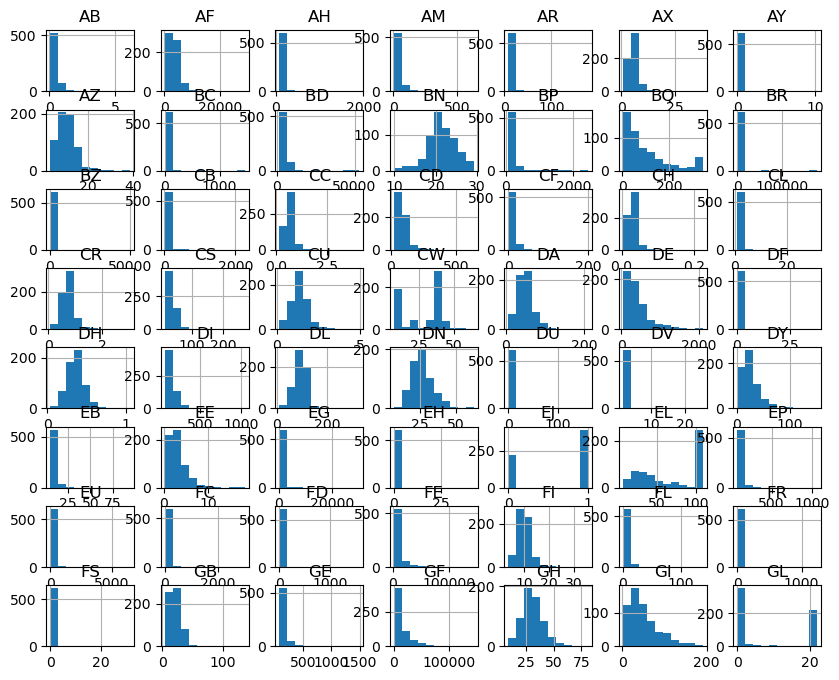

In [13]:
train_df[features].replace({'A': 0, 'B': 1}).hist(figsize=(10, 8))
plt.show()

The data is not normalized yet. Its a good practice to normalize the data first to boost performance.

## Imbalance data

In [14]:
print(train_df["Alpha"].value_counts())

0    509
1     61
3     29
2     18
Name: Alpha, dtype: int64


The amount of class is not balanced, and there is not much data.

## Null values

In [15]:
len(train_df[train_df.isna().any(axis=1)])

69

There are NaN values in rows.

<Axes: >

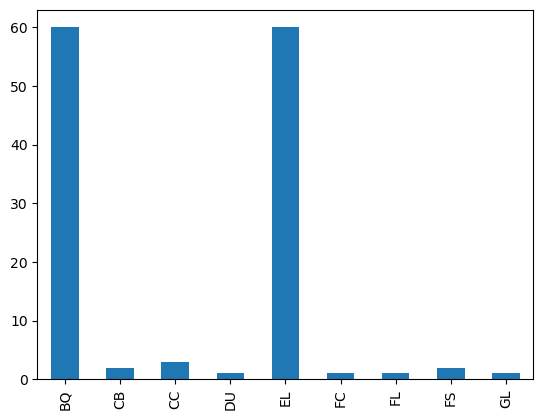

In [16]:
columns_with_na = train_df.apply(lambda x: len(x[x.isna()]), axis=0)
columns_with_na[columns_with_na>0].plot(kind="bar")

## Correlations

<Axes: >

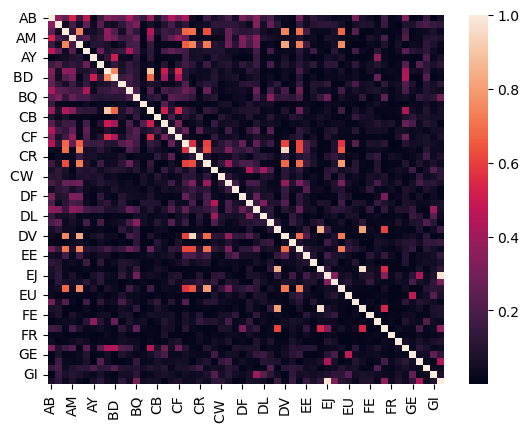

In [17]:
sns.heatmap(train_df[features].replace({'A': 0, 'B': 1}).corr().abs())

There are some highly correlated features. Feature selection is necessary.

## Outliers

In [18]:
scaled_df = train_df[features].replace({'A': 0, 'B': 1})
scaled_df = (scaled_df - scaled_df.mean(axis=0)) /  scaled_df.std(axis=0) 

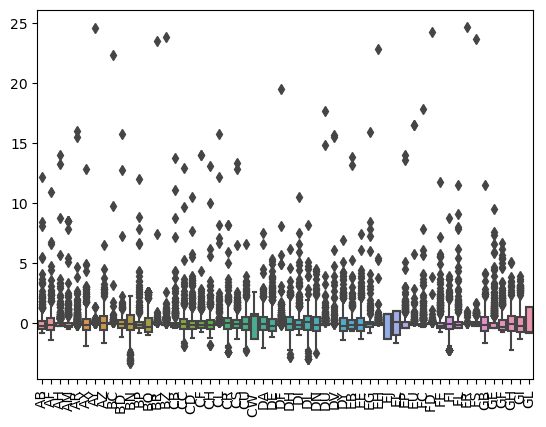

In [19]:
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.show()

Almost all features has outliers. Lets count the number of outliers in each columns. I will use the IQR method.

<Axes: >

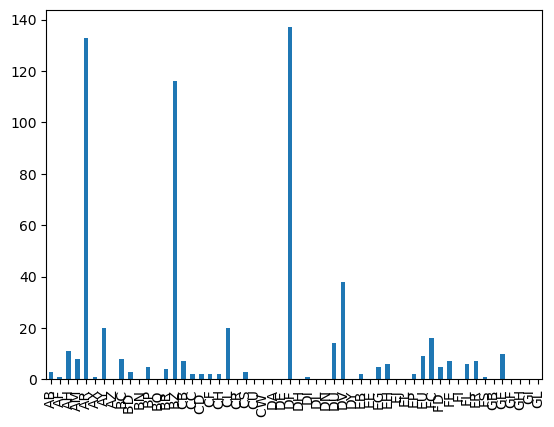

In [20]:
Q1 = scaled_df.quantile(0.25, axis=0)
Q3 = scaled_df.quantile(0.75, axis=0)
IQR = Q3 - Q1

outliers_count = scaled_df.apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

- Should we drop the columns with many (more than 10%) outliers?
- Should we drop the rows with outliers?
- Should we clip the values?

## Data processing todo list:
1. Remove trailing space in column names
2. Convert EJ column values from A and B to 0 and 1 respectively.
3. Handle NaN.
4. Handle outliers
5. Normalize dataset
6. Feature selection
7. Handle imbalance dataset

# Data processing

## 1. Remove trailing space in column names

In [21]:
train_df = train_df.rename(columns=lambda x: x.strip())
features = [n for n in train_df.columns if n not in ['Id', 'Class', 'Alpha', 'Epsilon']]

## 2. Convert EJ column values from A and B to 0 and 1 respectively

In [22]:
train_df["EJ"] = train_df["EJ"].replace({'A': 0, 'B': 1})
train_df["EJ"].head()

0    1
1    0
2    1
3    1
4    1
Name: EJ, dtype: int64

## 3. Handle NaN

### Create new_df for experimental dataset

In [23]:
new_df = train_df.copy()

### Impute data

In [24]:
imputer = SimpleImputer(strategy='mean')
new_df[features] = imputer.fit_transform(new_df[features])

In [25]:
len(new_df[features][new_df[features].isna().any(axis=1)])

0

## 4. Handle outliers

### Count extreme outliers in each columns.

<Axes: >

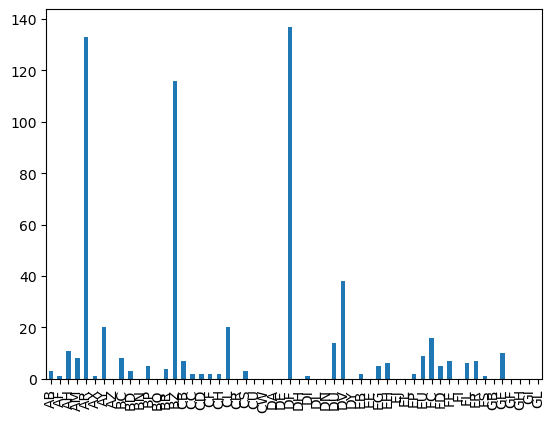

In [26]:
Q1 = new_df[features].quantile(0.25, axis=0)
Q3 = new_df[features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

## Handling extreme outliers

### Delete features with more than 10% outliers

In [27]:
to_remove = outliers_count[outliers_count/len(train_df)>.1]
to_remove

AR    133
BZ    116
DF    137
dtype: int64

In [28]:
good_features = list(set(features) - set(to_remove.index))
good_features.sort()

### Handling the rest

In [29]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False

    def fit(self, X, y=None):
        if self.fitted:
            return self
        
        Q1 = np.quantile(X, q=0.25, axis=0)
        Q3 = np.quantile(X, q=0.75, axis=0)
        IQR = Q3 - Q1
        
        self.lower = Q1-10*IQR
        self.upper = Q3+10*IQR
        
        self.fitted = True
        return self

    def transform(self, X):
        X = self.lower*(X<self.lower)+X*(X>=self.lower)
        X = self.upper*(X>self.upper)+X*(X<=self.upper)
        return X

In [30]:
outlier_handler = OutlierHandler()
new_df[good_features] = outlier_handler.fit_transform(new_df[good_features])

## Count extreme outliers after handled

<Axes: >

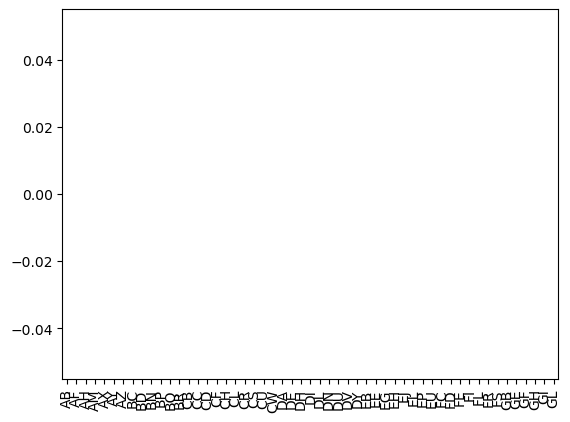

In [31]:
Q1 = new_df[good_features].quantile(0.25, axis=0)
Q3 = new_df[good_features].quantile(0.75, axis=0)
IQR = Q3 - Q1
outliers_count = new_df[good_features].apply(lambda x: len(x[((x<(Q1[x.name]-10*IQR[x.name])) | (x>(Q3[x.name]+10*IQR[x.name])))]), axis=0)
outliers_count.plot(kind="bar")

### Some features become a constant ofter handling outliers. Delete this features

In [32]:
const_features = new_df[good_features].apply(lambda x: x.min()==x.max(), axis=0)
const_features = const_features[const_features].index
const_features

Index(['DV'], dtype='object')

In [33]:
good_features = list(set(good_features) - set(const_features))
good_features.sort()

## 5. Normalize dataset

For the normalization method, I will use the power_transform method.

In [34]:
to_normalize = list(set(good_features) - set(["EJ"]))

In [35]:
normalizer = pp.PowerTransformer(standardize=False)
new_df[to_normalize] = normalizer.fit_transform(new_df[to_normalize])

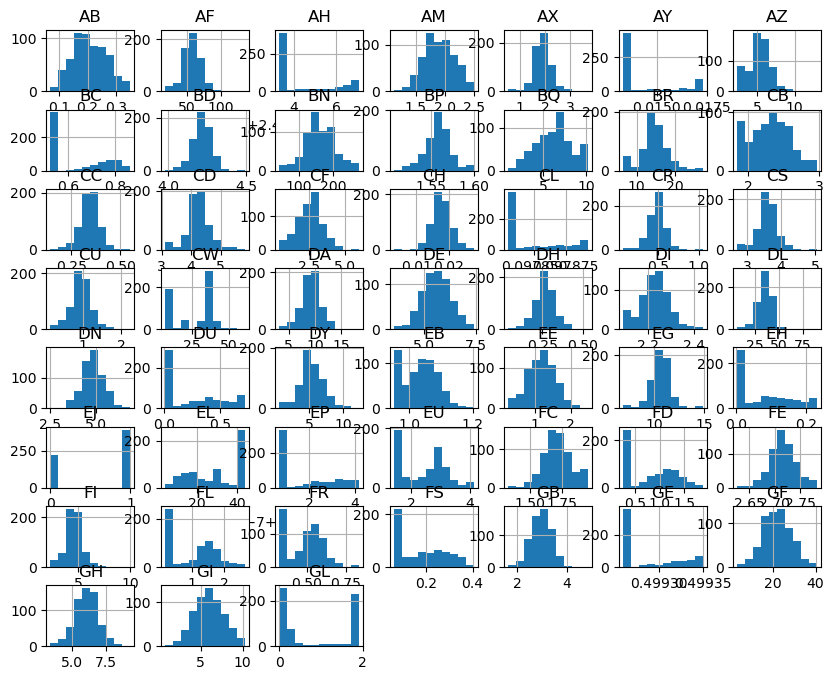

In [36]:
new_df[good_features].hist(figsize=(10, 8))
plt.show()

## 6. Feature selection

### List some highly correlated features

In [37]:
correlation_matrix = train_df[good_features].corr().abs()
high_correlation = correlation_matrix.unstack().sort_values(ascending=False)
high_correlation = high_correlation[(high_correlation>0.9) & (high_correlation!=1)].drop_duplicates()
high_correlation = list(high_correlation.index)
highly_correlated_features = list(set([item for sublist in high_correlation for item in sublist]))
high_correlation

[('EJ', 'GL'), ('FD', 'EH')]

### Investigate each features

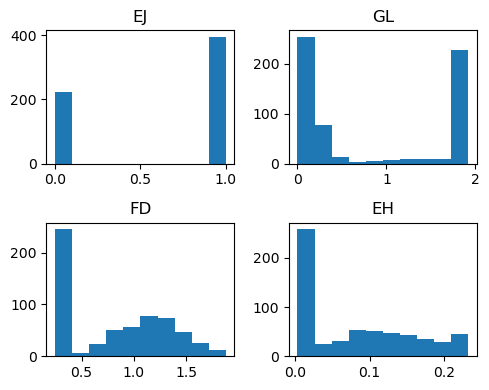

In [38]:
fig, axs = plt.subplots(len(high_correlation), 2, figsize=(5, 2*len(high_correlation)))

for i, (col1, col2) in enumerate(high_correlation):
    axs[i, 0].hist(new_df[col1])
    axs[i, 0].set_title(f'{col1}')
    axs[i, 1].hist(new_df[col2])
    axs[i, 1].set_title(f'{col2}')

plt.tight_layout()
plt.show()

In [39]:
new_df[["EJ", "GL", "Alpha"]].corr().abs()["Alpha"].sort_values(ascending=False)

Alpha    1.000000
EJ       0.044620
GL       0.001626
Name: Alpha, dtype: float64

Deleting GL column because EJ column is more correlated with the target.

In [40]:
new_df[["EH", "FD", "Alpha"]].corr().abs()["Alpha"].sort_values(ascending=False)

Alpha    1.000000
FD       0.015532
EH       0.000150
Name: Alpha, dtype: float64

Deleting EH column because FD column is more correlated with the target.

In [41]:
good_features = list(set(good_features) - set(['GL', 'EH']))
len(good_features)

50

<Axes: >

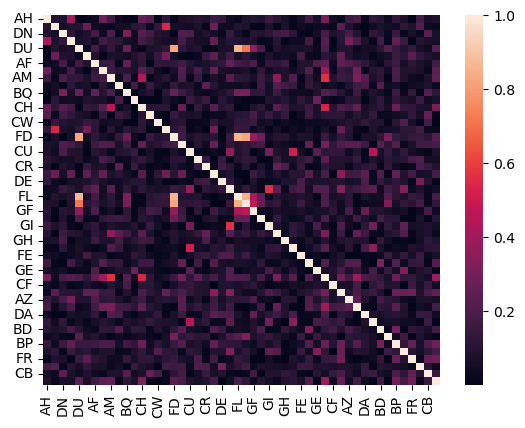

In [42]:
sns.heatmap(new_df[good_features].corr().abs())

## 7. Handle imbalance dataset

I will use oversampling method to handle imbalance data.

In [43]:
ros = RandomOverSampler(random_state=200)

new_df, y_alpha = ros.fit_resample(new_df, new_df["Alpha"])

In [44]:
print(new_df["Alpha"].value_counts())

1    509
0    509
2    509
3    509
Name: Alpha, dtype: int64


### Save custom good features

In [45]:
with open(f'good_features.pkl', 'wb') as f:
    pickle.dump(good_features, f)

# Model Training

Model reference: https://www.kaggle.com/code/vadimkamaev/postprocessin-ensemble

## Competition loss function

In [46]:
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

def balanced_log_loss_scorer(estimator, X, y_t):
    estimator = ModelWrapper(estimator)
    y_p = estimator.predict(X)
    y_t[y_t>0] = 1
    score = -balanced_log_loss(y_t, y_p)
    return score

## Useful Classes

In [47]:
class ModelWrapper(BaseEstimator):
    __sklearn_is_fitted__ = lambda: True
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y=None, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((len(p0),))
        for i in range(len(p0)):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        return y_p.astype(int)
        
    def predict_proba(self, X):
        averaged_probabilities = self.model.predict_proba(X)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        y_pred = new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        return probabilities

class Preprocessor(TransformerMixin):
    def __init__(self):
        self.sampler = RandomOverSampler(random_state=1)
        self.preprocessor = make_pipeline(
            SimpleImputer(strategy='mean'),
            OutlierHandler(),
            pp.PowerTransformer(standardize=False)
        )

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self
    
    def fit_resample(self, X, y):
        X = self.fit_transform(X)
        return self.sampler.fit_resample(X, y)

    def transform(self, X):
        return self.preprocessor.transform(X)

    def fit_transform(self, X, y=None):
        return self.preprocessor.fit_transform(X, y)

In [48]:
class TabPFNClassifier2(TabPFNClassifier):
    def fit(self, X, y, **kwargs):
        super().fit(X, y, overwrite_warning=True, **kwargs)

## Useful functions

In [49]:
def make_model(preprocessor, estimator):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("model", ModelWrapper(estimator))
    ])

def make_final_model(preprocessor, X, y):
    estimator = es.VotingClassifier([
        ("XGBClassifier1", XGBClassifier(n_estimators=100,max_depth=3,learning_rate=0.2,subsample=0.9,colsample_bytree=0.85)),
        ("XGBClassifier2", XGBClassifier()),
        ("TabPFNClassifier1", TabPFNClassifier2(N_ensemble_configurations=24)),
        ("TabPFNClassifier2", TabPFNClassifier2(N_ensemble_configurations=64))
    ], voting='soft', n_jobs=1)
    
    model = ModelWrapper(estimator)
    model.fit(X, y)
    return model, make_model(preprocessor, estimator)

## Prepare training data

In [50]:
X_train, y_train = train_df[good_features+extra_features].copy(), train_df["Alpha"].copy()

## Train the model

In [51]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
preprocessor = Preprocessor()
X, y = preprocessor.fit_resample(X_train.values, y_train.values)
best_loss = np.inf
for split, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    model = make_final_model(preprocessor, X[train_idx], y[train_idx])
    loss = -balanced_log_loss_scorer(model[0], X[val_idx], y[val_idx])
    scores.append(loss)
    
    if loss<best_loss:
        best_model = model[1]
        best_loss = loss
        print('best_model_saved')

    print('>val_loss=%.5f, split = %.1f' % (loss,split+1))
    
score = np.mean(scores)
print(score)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
best_model_saved
>val_loss=0.00000, split = 1.0
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
>val_loss=0.21560, split = 2.0
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 

# Submission

In [52]:
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test_df["Epsilon"] = train_df["Epsilon"].std()

test_df = test_df.rename(columns=lambda x: x.strip())
test_df["EJ"] = test_df["EJ"].replace({'A': 0, 'B': 1})

In [53]:
y_pred = best_model.predict_proba(test_df[good_features+extra_features].values)
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
p0 = probabilities[:,:1]
p0[p0 > 0.59] = 1 
p0[p0 < 0.28] = 0

In [54]:
submission = pd.DataFrame(test_df["Id"], columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('submission.csv', index=False)

In [55]:
submission_df = pd.read_csv('submission.csv')
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
